# Gradient Boosting Classifier

In [35]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import *
import pickle
import sys
import joblib
import os
import keras_tuner as kt

IMAGE_SIZE = [32, 32]

In [2]:
df = pd.read_json('../data/labelled_data/whole_data_1637521796.json', orient='records')

In [3]:
# Show amount of samples
print("amount of samples:", df.shape[0])
df.head(n=3)

amount of samples: 200


,index,Timestamp,Sensor ID,Room Temperature,RSSI,data,changed,label
521,521,2021-05-07 13:06:24,3078,21.299999,-67,"[[12.0, 10.4, 11.1, 10.9, 10.9, 12.0, 11.6, 11...",True,Human
2940,2940,2021-05-07 13:10:22,3078,22.400000,-76,"[[11.8, 10.3, 11.2, 11.8, 10.6, 11.3, 11.4, 11...",True,Human
226,226,2021-05-07 13:05:55,3078,21.100000,-68,"[[11.5, 10.5, 12.0, 12.5, 12.6, 13.0, 12.6, 12...",True,Ambigous heat


In [4]:
# convert labels
binary_label_converter = { 
    'Human': 1,
    'Several humans': 1, 
    'Non-human heat': 0, 
    'Ambigous heat': 0,
    'No heat':  0,
}


df_binary = df.copy()

df_binary['label'] = df['label'].apply(lambda x: binary_label_converter[x])
df_binary.head(n=3)

,index,Timestamp,Sensor ID,Room Temperature,RSSI,data,changed,label
521,521,2021-05-07 13:06:24,3078,21.299999,-67,"[[12.0, 10.4, 11.1, 10.9, 10.9, 12.0, 11.6, 11...",True,1
2940,2940,2021-05-07 13:10:22,3078,22.400000,-76,"[[11.8, 10.3, 11.2, 11.8, 10.6, 11.3, 11.4, 11...",True,1
226,226,2021-05-07 13:05:55,3078,21.100000,-68,"[[11.5, 10.5, 12.0, 12.5, 12.6, 13.0, 12.6, 12...",True,0


In [5]:
# Prepare the data
y = df_binary['label'].to_numpy()
X = np.array(df_binary['data'].to_list())
X = np.expand_dims(X, axis=3)
print(y.shape)
print(X.shape)

(200,)
(200, 32, 32, 1)


In [6]:
# Create train / val / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.25, random_state=0)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(y_train[:1])

(180, 32, 32, 1)
(180,)
(15, 32, 32, 1)
(15,)
[0]


In [7]:
# Squeezenet Model

bnmomemtum=0.9

def fire(x, squeeze, expand):
    y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
    y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
    y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
    y1 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y1)
    y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
    y3 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y3)
    return tf.keras.layers.concatenate([y1, y3])

def fire_module(squeeze, expand):
    return lambda x: fire(x, squeeze, expand)

x = tf.keras.layers.Input(shape=[*IMAGE_SIZE,1]) # input is 32x32 pixels RGB
y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', use_bias=True, activation='relu')(x)
y = tf.keras.layers.GlobalAveragePooling2D()(y)
y = tf.keras.layers.Dense(64)(y)
y = tf.keras.layers.Dense(32)(y)
y = tf.keras.layers.Dropout(0.2)(y)
y = tf.keras.layers.Dense(2, activation='softmax')(y)

model = tf.keras.Model(x, y)

In [8]:
model.compile(
optimizer='adam',
loss= 'sparse_categorical_crossentropy',
metrics=['accuracy'])
model.build(input_shape=(None, 32, 32, 1))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66    

In [9]:
# Plot the model
# `rankdir='LR'` is to make the graph horizontal.
%matplotlib inline
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


Epoch 1/30
12/12 [==============================] - 6s 52ms/step - loss: 1.1660 - accuracy: 0.5167 - val_loss: 0.8574 - val_accuracy: 0.6000
Epoch 2/30
12/12 [==============================] - 0s 13ms/step - loss: 0.7542 - accuracy: 0.5667 - val_loss: 0.6825 - val_accuracy: 0.6000
Epoch 3/30
12/12 [==============================] - 0s 16ms/step - loss: 0.6700 - accuracy: 0.6222 - val_loss: 0.7082 - val_accuracy: 0.6000
Epoch 4/30
12/12 [==============================] - 0s 16ms/step - loss: 0.6598 - accuracy: 0.6167 - val_loss: 0.6739 - val_accuracy: 0.6000
Epoch 5/30
12/12 [==============================] - 0s 14ms/step - loss: 0.7027 - accuracy: 0.5611 - val_loss: 0.6744 - val_accuracy: 0.6000
Epoch 6/30
12/12 [==============================] - 0s 13ms/step - loss: 0.6663 - accuracy: 0.6444 - val_loss: 0.6787 - val_accuracy: 0.6000
Epoch 7/30
12/12 [==============================] - 0s 13ms/step - loss: 0.6561 - accuracy: 0.6167 - val_loss: 0.6762 - val_accuracy: 0.6000
Epoch 8/30
12

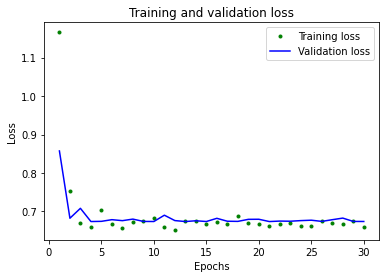

In [10]:
# Fit the model
EPOCHS = 30
BATCH_SIZE = 16
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))


train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Plot training history
plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [11]:
def get_feature_map_list(model):
    
    feature_map_list = []
        
    for i in range(len(model.layers)):
        layer = model.layers[i]
        # check for convolutional layer
        if 'conv' not in layer.name:
            continue
        # summarize output shape
        print(i, layer.name, layer.output.shape)
        
        # Get the layer input and output
        if i==0:
            inputs = model.inputs
        else:
            inputs = model.layers[i-1].input
            
        if i==len(model.layers):
            outputs = model.outputs
        else:
            outputs = model.layers[i].output
        
        current_feature_map = tf.keras.Model(name=layer.name, inputs=inputs, outputs=model.layers[i].output)
        feature_map_list.append(current_feature_map)
    
    return feature_map_list
        
    
    

In [12]:
layer_list = get_feature_map_list(model)
print(layer_list)

for i in range(len(layer_list)):
    layer_list[i].save(f"layer_{i}")

1 conv2d (None, 32, 32, 32)
INFO:tensorflow:Assets written to: layer_0\assets


In [13]:
# Calculate the feature map mean
feature_map_list = []

im_mean = np.mean(X, axis=(1,2))
im_median = np.median(X, axis=(1,2))
im_std = np.std(X, axis=(1,2))
im_max = np.max(X, axis=(1,2))
im_min = np.min(X, axis=(1,2))
im_sum = np.sum(X, axis=(1,2))

feature_map_list.append(np.concatenate([im_mean,
                                           im_median,
                                           im_std,
                                           im_max,
                                           im_min,
                                           im_sum], axis=1))



# Print the shape of the feature maps
for i in range(len(layer_list)):
    feature_map = layer_list[i].predict(X)
    feature_map_mean = np.mean(feature_map, axis=(1,2))
    feature_map_median = np.median(feature_map, axis=(1,2))
    feature_map_std = np.std(feature_map, axis=(1,2))
    feature_map_max = np.max(feature_map, axis=(1,2))
    feature_map_min = np.min(feature_map, axis=(1,2))
    feature_map_sum = np.sum(feature_map, axis=(1,2))
    feature_map_features = np.concatenate([feature_map_mean,
                                           feature_map_median,
                                           feature_map_std,
                                           feature_map_max, 
                                           feature_map_min, 
                                           feature_map_sum], axis=1)
    feature_map_list.append(feature_map_features)
    
feature_map_means = np.concatenate(feature_map_list, axis=1)
print(feature_map_means.shape)
print(feature_map_means[:1])

(200, 198)
[[1.37223633e+01 1.36000000e+01 1.41247853e+00 1.93000000e+01
  9.80000000e+00 1.40517000e+04 4.72798311e-05 0.00000000e+00
  7.79173449e-02 9.72959772e-03 0.00000000e+00 4.62327391e-01
  3.13297898e-01 4.68601324e-02 0.00000000e+00 1.47289917e-01
  0.00000000e+00 5.69383465e-02 0.00000000e+00 7.57527724e-02
  9.00700763e-02 3.60940496e-04 0.00000000e+00 1.91350409e-03
  1.39959842e-01 2.93643139e-02 1.35611233e-04 8.70626979e-03
  6.02895357e-02 0.00000000e+00 2.32827421e-02 1.16444558e-01
  1.06699942e-02 0.00000000e+00 7.34603927e-02 2.21655164e-02
  3.57677728e-01 4.26867634e-01 0.00000000e+00 0.00000000e+00
  1.36925932e-03 0.00000000e+00 0.00000000e+00 4.40890640e-01
  1.09904535e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.26051769e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+

In [14]:
df_train_binary_expanded = pd.DataFrame(np.concatenate([df_binary.head(X.shape[0]), feature_map_means], axis=1))

In [15]:
df_train_binary_expanded.head(n=2)

,0,1,2,3,4,5,6,7,8,9,...,196,197,198,199,200,201,202,203,204,205
0,521,2021-05-07 13:06:24,3078,21.299999,-67,"[[12.0, 10.4, 11.1, 10.9, 10.9, 12.0, 11.6, 11...",True,1,13.722363,13.6,...,61.736485,0.0,23.841528,119.239227,10.926074,0.0,75.223442,22.697489,366.261993,437.112457
1,2940,2021-05-07 13:10:22,3078,22.4,-76,"[[11.8, 10.3, 11.2, 11.8, 10.6, 11.3, 11.4, 11...",True,1,13.538184,13.5,...,53.503193,0.0,21.682627,103.423027,11.643206,0.0,67.96666,21.426983,370.783905,427.765198


In [16]:
# Prepare the data for gradient boosting
y_clf = df_train_binary_expanded[7].to_numpy().astype(int)
X_clf= df_train_binary_expanded.iloc[:,8:].to_numpy()
print(y_clf.shape)
print(X_clf.shape)

(200,)
(200, 198)


In [30]:
# Create train / val / test split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.1, random_state=0)
# X_val_clf, X_test_clf, y_val_clf, y_test_clf = train_test_split(X_test_clf, y_test_clf, test_size=0.3, random_state=0)

print(X_train_clf.shape)
print(y_train_clf.shape)
print(X_test_clf.shape)
print(y_test_clf.shape)
print(y_train_clf[:1])

(180, 198)
(180,)
(20, 198)
(20,)
[0]


In [31]:
# Train the GBT
clf = GradientBoostingClassifier(n_estimators=300, learning_rate=1.0, max_depth=3, random_state=0).fit(X_train_clf, y_train_clf)

# Mean accuracy
clf.score(X_test_clf, y_test_clf)

0.7

In [32]:
# Get the model size in kiB
def get_memory_size(clf, layer_list, fname = "clf"):
    joblib.dump(clf, fname)
    model_size = os.path.getsize(fname)
    model_size = model_size / 1024
    print(f"GBT size in kiB: {model_size}")

    # Get the conv layers size in kiB
    layer_size = 0
    for i in range(len(layer_list)):
        layer_size = os.path.getsize(f"layer_{i}")
    layer_size = layer_size / 1024
    print(f"Conv layer size in kiB: {layer_size}")

    # Total size for GBT in kiB
    print(f"Total size in kiB: {layer_size + model_size}")
    
get_memory_size(clf, layer_list)

GBT size in kiB: 318.7744140625
Conv layer size in kiB: 4.0
Total size in kiB: 322.7744140625


In [33]:
# HP-Tuning
NUM_FEATURES = 198

def build_hypermodel(hp):
    
    n_estimators = hp.Int("n_estimators", 10, 300)
    learning_rate = hp.Float("learning_rate", 0.1, 1.0)
    max_depth = hp.Int("max_depth", 1, 8)
    max_features = hp.Int("max_features", 1, NUM_FEATURES)
    
    return GradientBoostingClassifier(n_estimators=n_estimators,
                                      learning_rate=learning_rate, 
                                      max_depth=max_depth,
                                      max_features=max_features,
                                      validation_fraction=0.2,
                                      random_state=0)


In [38]:
MAX_TRIALS = 5

# TODO: Implement a custom tuner class to be able to use other metrics!

tuner = kt.tuners.SklearnTuner(
    oracle=kt.oracles.BayesianOptimizationOracle(
        objective=kt.Objective(balanced_accuracy_score, 'max'),
        max_trials=MAX_TRIALS),
    hypermodel=build_hypermodel,
    scoring=skl.metrics.make_scorer(skl.metrics.accuracy_score),
    cv=skl.model_selection.StratifiedKFold(5),
    directory='.',
    project_name='hp_tuning')



tuner.search(X_train_clf, y_train_clf)

best_model = tuner.get_best_models(num_models=1)[0]

print(f"Best model test score: {best_model.score(X_test_clf, y_test_clf)}")

print(f"Best model params: {best_model.get_params()}")

INFO:tensorflow:Reloading Oracle from existing project .\hp_tuning\oracle.json

Search: Running Trial #2

Hyperparameter    |Value             |Best Value So Far 
n_estimators      |120               |?                 
learning_rate     |0.87053           |?                 
max_depth         |2                 |?                 
max_features      |95                |?                 



ValueError: Objective value missing in metrics reported to the Oracle, expected: [<function balanced_accuracy_score at 0x000001F4A9AD7670>], found: dict_keys(['score'])

In [22]:
get_memory_size(best_model, layer_list, fname="best")

GBT size in kiB: 24.25390625
Conv layer size in kiB: 4.0
Total size in kiB: 28.25390625


In [26]:
# make and show single prediciton
%matplotlib inline

n=4 # pics per row

label = {1: 'Human',
         0: 'No Human'}

pred = best_model.predict(X_test_clf)

print(pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
